In [13]:
"""CS231n: Optimization
"""

import numpy as np
import matplotlib.pyplot as plt
import pickle, os, random
from collections import Counter
from ipywidgets import interact, IntSlider, Dropdown
from sklearn.datasets import make_moons, make_circles, make_blobs


In [22]:
# CIFAR-10 Loading Utilities

def load_CIFAR_batch(filename):
    with open(filename, 'rb') as f:
        datadict = pickle.load(f, encoding='bytes')
        X = datadict[b'data']
        Y = datadict[b'labels']
        # reshape to (N, C, H, W) then transpose to (N, H, W, C) for channel-last format
        X = X.reshape(10000, 3, 32, 32).astype("float").transpose(0, 2, 3, 1)
        Y = np.array(Y)
        return X, Y

def load_CIFAR10(folder_path):
    xs, ys = [], []
    for b in range(1, 6):
        f = os.path.join(folder_path, f'data_batch_{b}')
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    Xte, Yte = load_CIFAR_batch(os.path.join(folder_path, 'test_batch'))
    return Xtr, Ytr, Xte, Yte

X_train, y_train, X_test, y_test = load_CIFAR10('../cifar-10-batches-py')

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


In [23]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [24]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


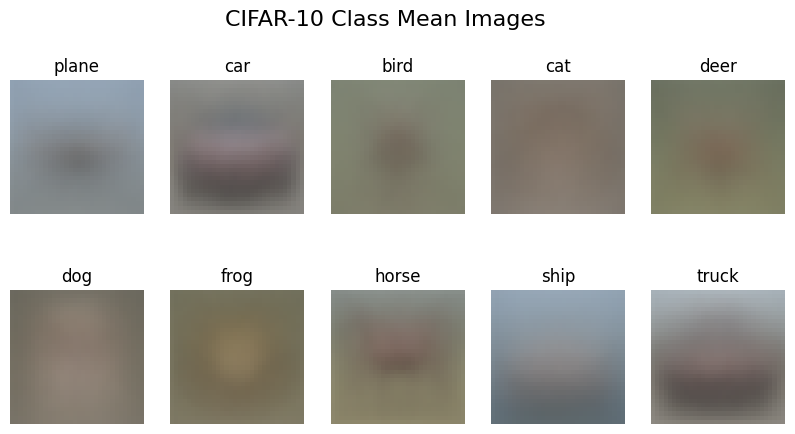

In [27]:
# Compute the image mean for each class

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
class_image_means = {}
for y in range(10):
    X_class = X_train[y_train == y]
    class_image_means[y] = np.mean(X_class, axis=0)

# show class means
plt.figure(figsize=(10,5))
for y in range(10):
    plt.subplot(2, 5, y+1)
    plt.imshow(class_image_means[y].reshape(32,32,3).astype('uint8'))
    plt.axis('off')
    plt.title(f'{classes[y]}')
plt.suptitle('CIFAR-10 Class Mean Images', fontsize=16)
plt.show()

[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


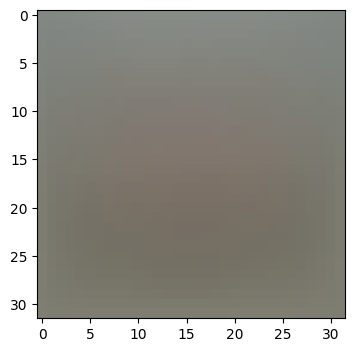

In [28]:
# Preprocessing: subtract the mean image
# first: compute the image mean for the training data

mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image



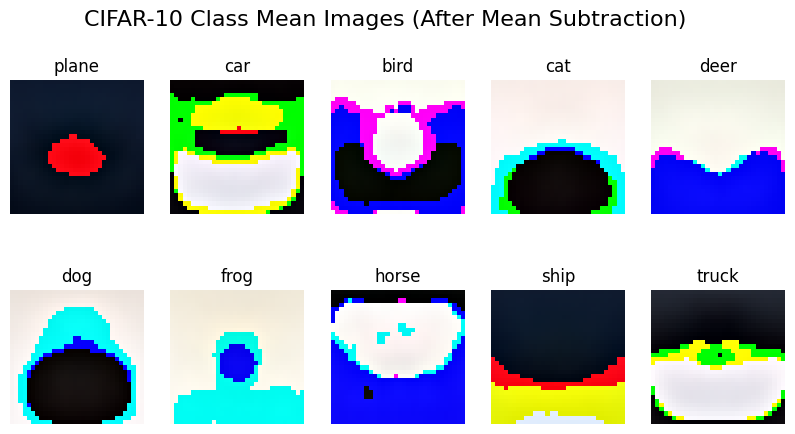

In [29]:
# Compute the image mean for each class (after subtracting overall mean)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
class_image_means = {}
for y in range(10):
    X_class = X_train[y_train == y]
    class_image_means[y] = np.mean(X_class, axis=0)

# show class means
plt.figure(figsize=(10,5))
for y in range(10):
    plt.subplot(2, 5, y+1)
    plt.imshow(class_image_means[y].reshape(32,32,3).astype('uint8'))
    plt.axis('off')
    plt.title(f'{classes[y]}')
plt.suptitle('CIFAR-10 Class Mean Images (After Mean Subtraction)', fontsize=16)
plt.show()

In [30]:
# third: append the bias dimension of ones (i.e. bias trick) so that our classifier
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


In [32]:
# Loss Function Definitions

def scores(X, W):
    """
    Compute the scores given the data and weights.
    - X is the data matrix where each row is a data point.
    - W is the weight matrix.
    Returns the scores matrix.
    """
    return W @ X.T

def L_i(x, y, W):
  """
  unvectorized version. Compute the multiclass svm loss for a single example (x,y)
  - x is a column vector representing an image (e.g. 3073 x 1 in CIFAR-10)
    with an appended bias dimension in the 3073-rd position (i.e. bias trick)
  - y is an integer giving index of correct class (e.g. between 0 and 9 in CIFAR-10)
  - W is the weight matrix (e.g. 10 x 3073 in CIFAR-10)
  """
  delta = 1.0 # see notes about delta later in this section
  scores = W.dot(x) # scores becomes of size 10 x 1, the scores for each class
  correct_class_score = scores[y]
  D = W.shape[0] # number of classes, e.g. 10
  loss_i = 0.0
  for j in range(D): # iterate over all wrong classes
    if j == y:
      # skip for the true class to only loop over incorrect classes
      continue
    # accumulate loss for the i-th example
    loss_i += max(0, scores[j] - correct_class_score + delta)
  return scores, loss_i

def L_i_vectorized(x, y, W):
  """
  A faster half-vectorized implementation. half-vectorized
  refers to the fact that for a single example the implementation contains
  no for loops, but there is still one loop over the examples (outside this function)
  """
  delta = 1.0
  scores = W.dot(x)
  # compute the margins for all classes in one vector operation
  margins = np.maximum(0, scores - scores[y] + delta)
  # on y-th position scores[y] - scores[y] canceled and gave delta. We want
  # to ignore the y-th position and only consider margin on max wrong class
  margins[y] = 0
  loss_i = np.sum(margins)
  return scores, loss_i

def L(X, y, W):
  """
  fully-vectorized implementation :
  - X holds all the training examples as columns (e.g. 3073 x 50,000 in CIFAR-10)
  - y is array of integers specifying correct class (e.g. 50,000-D array)
  - W are weights (e.g. 10 x 3073)
  """
  # evaluate loss over all examples in X without using any for loops
  # left as exercise to reader in the assignment
  delta = 1.0
  score = scores(X, W)  # shape (C, N)
  correct_class_scores = score[y, np.arange(X.shape[0])]  # shape (N,)
  margins = np.maximum(0, correct_class_scores - score + delta)  # shape (C, N)
  margins[y, np.arange(X.shape[0])] = 0  # zero out correct class margins
  loss = np.sum(margins)
  return score, loss

  

In [33]:
# Strategy 1: Random Search

np.random.seed(42)
# seed 0 best loss = 3966.41
# seed 3 best loss = 3912.75
# seed 20 best loss = 3968.10
# seed 42 best loss = 3893.36
bestloss = float('inf')
for num in range(1000):
    W = np.random.randn(10, 3073) * 0.0001 # generate random weights
    s, loss = L(X_dev, y_dev, W)
    if loss < bestloss:
        bestloss = loss
        bestW = W
    print(f'in attempt {num} the loss was {loss} (best loss: {bestloss:.2f})')

in attempt 0 the loss was 4681.532979836529 (best loss: 4681.53)
in attempt 1 the loss was 4423.4393474019125 (best loss: 4423.44)
in attempt 2 the loss was 4926.340176217874 (best loss: 4423.44)
in attempt 3 the loss was 4610.212165986841 (best loss: 4423.44)
in attempt 4 the loss was 4669.954664307294 (best loss: 4423.44)
in attempt 5 the loss was 4737.784805173961 (best loss: 4423.44)
in attempt 6 the loss was 4563.867120316652 (best loss: 4423.44)
in attempt 7 the loss was 4467.142361998925 (best loss: 4423.44)
in attempt 8 the loss was 4296.267450089592 (best loss: 4296.27)
in attempt 9 the loss was 4788.016664987423 (best loss: 4296.27)
in attempt 10 the loss was 4456.475598073631 (best loss: 4296.27)
in attempt 11 the loss was 4373.862577390425 (best loss: 4296.27)
in attempt 12 the loss was 4502.899455462164 (best loss: 4296.27)
in attempt 13 the loss was 4685.592931151178 (best loss: 4296.27)
in attempt 14 the loss was 4561.799726604686 (best loss: 4296.27)
in attempt 15 the l

In [34]:
# To see how well it works on the test set

score = scores(X_test, bestW)
Y_pred = np.argmax(score, axis=0)
accuracy = np.mean(Y_pred == y_test)
print(f'Random search accuracy on test set: {accuracy*100:.2f}%')

Random search accuracy on test set: 8.80%


In [35]:
# Strategy 2: Random Local Search

np.random.seed(0)
# seed 0 best loss = 4440.61
# seed 3 best loss = 5204.05
# seed 20 best loss = 4453.73
# seed 42 best loss = 4948.15
W = np.random.randn(10, 3073) * 0.001 # generate random starting W
bestloss = float("inf")
for num in range(1000):
  step_size = 0.0001
  Wtry = W + np.random.randn(10, 3073) * step_size
  _, loss = L(X_dev, y_dev, Wtry)
  if loss < bestloss:
    W = Wtry
    bestloss = loss
  print(f'in attempt {num} the loss was {loss} (best loss: {bestloss:.2f})')

in attempt 0 the loss was 9504.953000221085 (best loss: 9504.95)
in attempt 1 the loss was 9673.037594295056 (best loss: 9504.95)
in attempt 2 the loss was 9572.373207494731 (best loss: 9504.95)
in attempt 3 the loss was 9446.641050532042 (best loss: 9446.64)
in attempt 4 the loss was 9594.740694847162 (best loss: 9446.64)
in attempt 5 the loss was 9470.582520542499 (best loss: 9446.64)
in attempt 6 the loss was 9613.354345676142 (best loss: 9446.64)
in attempt 7 the loss was 9398.600413986536 (best loss: 9398.60)
in attempt 8 the loss was 9476.206924176964 (best loss: 9398.60)
in attempt 9 the loss was 9490.244740708564 (best loss: 9398.60)
in attempt 10 the loss was 9491.040387080207 (best loss: 9398.60)
in attempt 11 the loss was 9289.363719904282 (best loss: 9289.36)
in attempt 12 the loss was 9270.032134691282 (best loss: 9270.03)
in attempt 13 the loss was 9389.034414583293 (best loss: 9270.03)
in attempt 14 the loss was 9307.265337006493 (best loss: 9270.03)
in attempt 15 the lo

In [36]:
# To see how well it works on the test set

score = scores(X_test, bestW)
Y_pred = np.argmax(score, axis=0)
accuracy = np.mean(Y_pred == y_test)
print(f'Random local search accuracy on test set: {accuracy*100:.2f}%')

Random local search accuracy on test set: 8.80%


In [37]:
# Strategy 3: Following the Gradient

def eval_numerical_gradient(f, x):
  """
  a naive implementation of numerical gradient of f at x
  - f should be a function that takes a single argument
  - x is the point (numpy array) to evaluate the gradient at
  """

  fx = f(x) # evaluate function value at original point
  grad = np.zeros(x.shape)
  h = 0.00001

  # iterate over all indexes in x
  it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
  while not it.finished:

    # evaluate function at x+h
    ix = it.multi_index
    old_value = x[ix]
    x[ix] = old_value + h # increment by h
    fxh = f(x) # evalute f(x + h)
    x[ix] = old_value # restore to previous value (very important!)

    # compute the partial derivative
    grad[ix] = (fxh - fx) / h # the slope
    it.iternext() # step to next dimension

  return grad

In [38]:
# compute the numerical gradient for the CIFAR-10 loss function at some random point in the weight space

def CIFAR10_loss_fun(W):
  # L returns (scores, loss); numerical gradient function expects a scalar loss
  _, loss = L(X_dev, y_dev, W)
  return loss

np.random.seed(0)

W = np.random.rand(10, 3073) * 0.001 # random weight vector
df = eval_numerical_gradient(CIFAR10_loss_fun, W) # get the gradient

loss_original = CIFAR10_loss_fun(W) # the original loss
print(f'original loss: {loss_original}')

# lets see the effect of multiple step sizes
for step_size_log in [-10, -9, -8, -7, -6, -5,-4,-3,-2,-1]:
  step_size = 10 ** step_size_log
  W_new = W - step_size * df # new position in the weight space
  loss_new = CIFAR10_loss_fun(W_new)
  print(f'for step size {step_size} new loss: {loss_new}')

original loss: 6076.083363580405
for step size 1e-10 new loss: 5826.747403526153
for step size 1e-09 new loss: 4309.112501280722
for step size 1e-08 new loss: 10494.14342263991
for step size 1e-07 new loss: 97494.52349454709
for step size 1e-06 new loss: 970226.1082724626
for step size 1e-05 new loss: 9697731.118655175
for step size 0.0001 new loss: 96972781.22248226
for step size 0.001 new loss: 969723282.2607533
for step size 0.01 new loss: 9697228292.643463
for step size 0.1 new loss: 96972278396.47057


In [114]:
# Analytic Gradient

def svm_loss_and_gradient(W, x_i, y_i, delta=1.0):

    score = scores(x_i, W)               # shape (C,)
    correct_class_score = score[y_i]

    # Compute margins for all classes
    margins = np.maximum(0, score - correct_class_score + delta)
    margins[y_i] = 0  # The correct class doesn’t contribute to the loss

    loss_i = np.sum(margins)

    # Compute gradient
    dW_i = np.zeros_like(W)

    # Indicator: which classes contributed to the loss
    positive_margins = margins > 0

    # For incorrect classes: add x_i to rows that violated margin
    dW_i[positive_margins] += np.outer(np.ones(np.sum(positive_margins)), x_i)

    # For correct class: subtract (# of violations) * x_i
    num_violations = np.sum(positive_margins)
    dW_i[y_i] -= num_violations * x_i

    return loss_i, dW_i


In [115]:
# Example: 
np.random.seed(0)
W = np.random.randn(3, 5)
x_i = np.random.randn(5)
y_i = 1

loss_i, grad_i = svm_loss_and_gradient(W, x_i, y_i)

print("Loss:", loss_i)
print("Gradient:\n", grad_i)


Loss: 2.332964274642322
Gradient:
 [[ 0.33367433  1.49407907 -0.20515826  0.3130677  -0.85409574]
 [-0.66734865 -2.98815815  0.41031653 -0.6261354   1.70819148]
 [ 0.33367433  1.49407907 -0.20515826  0.3130677  -0.85409574]]


In [40]:
# Strategy 3: Following the gradient

# Taking a loss function
def loss_function(X, y, W):
    _, loss = L(X, y, W)
    return loss

def gradient_descent(X, y, W, loss_func, step_size=1e-7, num_iters=100):
    """
    Perform vanilla gradient descent to optimize weights W.
    """
    for _ in range(num_iters):
        weights_grad = eval_numerical_gradient(X, y, W, loss_func)
        W += - step_size * weights_grad  # update weights
    return W

def sgd(X, y, W, loss_func, step_size=1e-7, num_iters=100, batch_size=200):
    """
    Perform stochastic gradient descent to optimize weights W.
    """
    num_train = X.shape[0]
    for _ in range(num_iters):
        batch_indices = np.random.choice(num_train, batch_size)
        X_batch = X[batch_indices]
        y_batch = y[batch_indices]
        weights_grad = eval_numerical_gradient(X_batch, y_batch, W, loss_func)
        W += - step_size * weights_grad  # update weights
    return W

def sgd_simple(X_batch, y_batch, w, learning_rate, loss_func):
    while True:
        dx = eval_numerical_gradient(X_batch, y_batch, w, loss_func)
        w -= learning_rate * dx
        if np.linalg.norm(dx) < 1e-5:  # convergence criterion
            break
    return w

def sgd_momentum(X, y, W, loss_func, step_size=1e-7, num_iters=100, batch_size=200, momentum=0.9):
    """
    Perform stochastic gradient descent with momentum to optimize weights W.
    """
    num_train = X.shape[0]
    v = np.zeros_like(W)  # initialize velocity
    for _ in range(num_iters):
        batch_indices = np.random.choice(num_train, batch_size)
        X_batch = X[batch_indices]
        y_batch = y[batch_indices]
        weights_grad = eval_numerical_gradient(X_batch, y_batch, W, loss_func)
        v = momentum * v - step_size * weights_grad  # update velocity
        W += v  # update weights
    return W

def rmsprop(X, y, W, loss_func, step_size=1e-7, num_iters=100, batch_size=200, decay_rate=0.99, epsilon=1e-8):
    """
    Perform RMSProp to optimize weights W.
    """
    num_train = X.shape[0]
    cache = np.zeros_like(W)  # initialize cache
    for _ in range(num_iters):
        batch_indices = np.random.choice(num_train, batch_size)
        X_batch = X[batch_indices]
        y_batch = y[batch_indices]
        weights_grad = eval_numerical_gradient(X_batch, y_batch, W, loss_func)
        cache = decay_rate * cache + (1 - decay_rate) * (weights_grad ** 2)  # update cache
        W += - step_size * weights_grad / (np.sqrt(cache) + epsilon)  # update weights
    return W

def adam(X, y, W, loss_func, step_size=1e-7, num_iters=100, batch_size=200, beta1=0.9, beta2=0.999, epsilon=1e-8):
    """
    Perform Adam optimization to optimize weights W.
    """
    num_train = X.shape[0]
    m = np.zeros_like(W)  # initialize first moment
    v = np.zeros_like(W)  # initialize second moment
    for t in range(1, num_iters + 1):
        batch_indices = np.random.choice(num_train, batch_size)
        X_batch = X[batch_indices]
        y_batch = y[batch_indices]
        weights_grad = eval_numerical_gradient(X_batch, y_batch, W, loss_func)
        m = beta1 * m + (1 - beta1) * weights_grad  # update first moment
        v = beta2 * v + (1 - beta2) * (weights_grad ** 2)  # update second moment
        m_hat = m / (1 - beta1 ** t)  # bias-corrected first moment
        v_hat = v / (1 - beta2 ** t)  # bias-corrected second moment
        W += - step_size * m_hat / (np.sqrt(v_hat) + epsilon)  # update weights
    return W

In [41]:
# displaying the generation of weights

weight_intervals = [0, 1, 2, 3, 5, 10, 20, 50, 100] # iterations at which weights are stored

weights_over_time = []

for iter in range(101):
    W = sgd(X_train, y_train, W, loss_function, step_size=1e-7, num_iters=1, batch_size=200)
    if iter in weight_intervals:
        weights_over_time.append(W.copy())  # store a copy of the weights
# Now weights_over_time contains the weights at specified iterations    

# Visualizing the weight evolution
plt.figure(figsize=(15, 8))
for i, W in enumerate(weights_over_time):
    plt.subplot(3, 3, i + 1)
    plt.imshow(W[:, :-1].reshape(10, 32, 32, 3).mean(axis=0).astype('uint8'))  # visualize weights as images
    plt.title(f'Weights at iteration {weight_intervals[i]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

TypeError: eval_numerical_gradient() takes 2 positional arguments but 4 were given